## Importing Necessary Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [12]:
from sklearn.metrics import silhouette_score, classification_report
from sklearn.model_selection import ParameterGrid
from sklearn.mixture import GaussianMixture
from tqdm import tqdm
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import pickle

## Loading the Dataset

In [3]:
import shutil

# Source and destination paths
source = '/content/drive/MyDrive/OST/2018Floor3_features_selected.zip'
destination = '/content/data.zip'

# Copy the file
shutil.copy(source, destination)


'/content/data.zip'

In [4]:
import zipfile

# Path to the ZIP file and extraction folder
zip_path = '/content/data.zip'
extract_to = '/content/dataset/'

# Extract the ZIP file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)


In [5]:
import os

# List extracted files
print(os.listdir('/content/dataset/'))


['2018Floor3_features_selected.csv']


### Viewing Data

In [7]:
import pandas as pd

# Load a CSV file
df = pd.read_csv('/content/dataset/2018Floor3_features_selected.csv')

# Display the first few rows
df.head()


,z1_AC2(kW),z1_AC4(kW),z1_Plug(kW),z1_S1(RH%),z1_S1(lux),z2_AC1(kW),z2_Light(kW),z2_Plug(kW),z2_S1(RH%),z2_S1(lux),...,z4_AC1(kW),z4_Light(kW),z4_Plug(kW),z4_S1(RH%),z4_S1(lux),z5_AC1(kW),z5_Light(kW),z5_Plug(kW),z5_S1(RH%),z5_S1(lux)
0,0.0,8.74,0.22,62.50,0.0,0.0,0.0,0.15,65.74,0.0,...,0.0,0.0,0.07,0.0,0.0,0.0,0.0,0.15,62.86,0.0
1,0.0,8.74,0.23,62.50,0.0,0.0,0.0,0.15,65.74,0.0,...,0.0,0.0,0.07,0.0,0.0,0.0,0.0,0.14,62.87,0.0
2,0.0,8.61,0.22,62.50,0.0,0.0,0.0,0.15,65.74,0.0,...,0.0,0.0,0.08,0.0,0.0,0.0,0.0,0.14,62.88,0.0
3,0.0,8.81,0.23,62.50,0.0,0.0,0.0,0.15,65.73,0.0,...,0.0,0.0,0.08,0.0,0.0,0.0,0.0,0.14,62.88,0.0
4,0.0,8.89,0.22,62.51,0.0,0.0,0.0,0.15,65.73,0.0,...,0.0,0.0,0.07,0.0,0.0,0.0,0.0,0.14,62.88,0.0


## Preprocessing Data

In [9]:
features=list(df.columns)

In [10]:
features

['z1_AC2(kW)',
 'z1_AC4(kW)',
 'z1_Plug(kW)',
 'z1_S1(RH%)',
 'z1_S1(lux)',
 'z2_AC1(kW)',
 'z2_Light(kW)',
 'z2_Plug(kW)',
 'z2_S1(RH%)',
 'z2_S1(lux)',
 'z3_Light(kW)',
 'z3_Plug(kW)',
 'z4_AC1(kW)',
 'z4_Light(kW)',
 'z4_Plug(kW)',
 'z4_S1(RH%)',
 'z4_S1(lux)',
 'z5_AC1(kW)',
 'z5_Light(kW)',
 'z5_Plug(kW)',
 'z5_S1(RH%)',
 'z5_S1(lux)']

In [13]:

# Standardize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df)

# Apply PCA
PCA_COMPONENTS = 2  # Number of PCA components
pca = PCA(n_components=PCA_COMPONENTS)
pca_results = pca.fit_transform(scaled_data)

# Add PCA results back to the dataframe
df['PC1'] = pca_results[:, 0]
df['PC2'] = pca_results[:, 1]

### Gaussian Mixture Model (GMM) for Anomaly Detection

In [14]:
# Define and fit the Gaussian Mixture Model
GMM_CLUSTERS = 3  # Number of clusters
gmm = GaussianMixture(n_components=GMM_CLUSTERS, covariance_type='full', random_state=42)

# Fit the model and get predictions
df['gmm_cluster'] = gmm.fit_predict(scaled_data)

# Calculate the log-likelihood scores (anomaly scores)
df['gmm_log_likelihood'] = gmm.score_samples(scaled_data)

# Determine anomaly threshold
ANOMALY_PERCENTILE = 1  # Top 1% most unlikely points are anomalies
threshold = np.percentile(df['gmm_log_likelihood'], ANOMALY_PERCENTILE)

# Label anomalies: 1 for anomaly, 0 for normal
df['Anomaly'] = df['gmm_log_likelihood'].apply(lambda x: 1 if x < threshold else 0)


## Visualizing

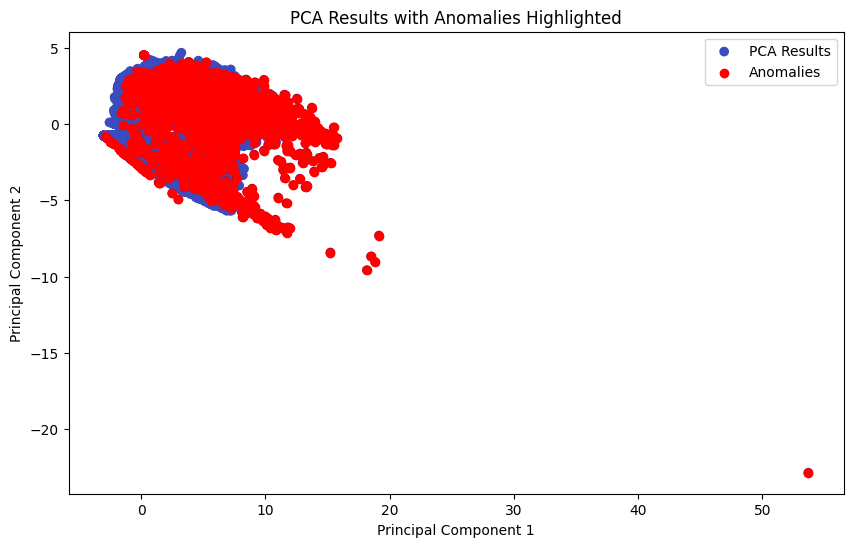

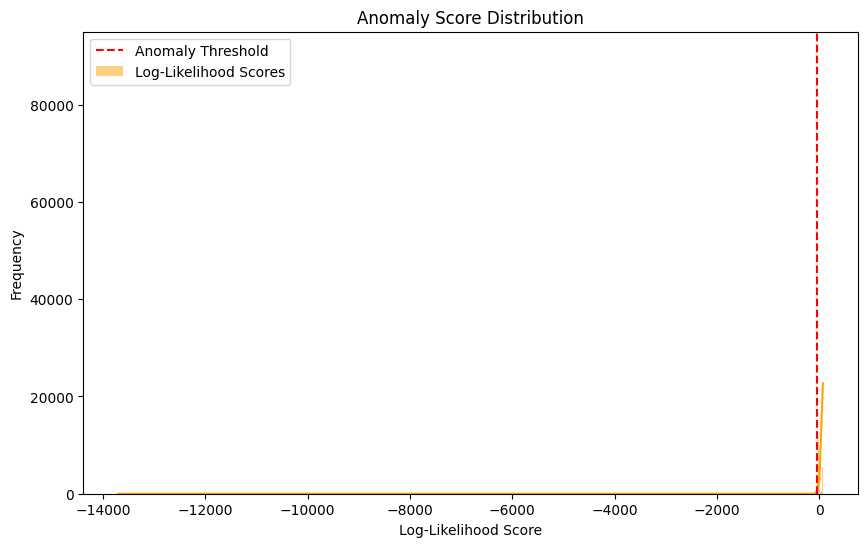

In [15]:
# Scatter plot of PCA results with anomalies highlighted
plt.figure(figsize=(10, 6))
plt.scatter(df['PC1'], df['PC2'], c=df['Anomaly'], cmap='coolwarm', label='PCA Results')
plt.scatter(
    df.loc[df['Anomaly'] == 1, 'PC1'],
    df.loc[df['Anomaly'] == 1, 'PC2'],
    color='red',
    label='Anomalies',
)
plt.title('PCA Results with Anomalies Highlighted')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

# Distribution plot of anomaly scores
plt.figure(figsize=(10, 6))
sns.histplot(df['gmm_log_likelihood'], kde=True, color='orange', label='Log-Likelihood Scores')
plt.axvline(x=threshold, color='red', linestyle='--', label='Anomaly Threshold')
plt.title('Anomaly Score Distribution')
plt.xlabel('Log-Likelihood Score')
plt.ylabel('Frequency')
plt.legend()
plt.show()


## Classification

### Data Preparation

In [19]:
from sklearn.utils import resample

# Check class distribution
print("Class distribution:\n", df['Anomaly'].value_counts())

# Separate majority and minority classes
normal = df[df['Anomaly'] == 0]
anomalies = df[df['Anomaly'] == 1]

# Oversample the minority class if there's an imbalance
anomalies_upsampled = resample(anomalies,
                                replace=True,
                                n_samples=len(normal),
                                random_state=42)

# Combine back into a balanced dataset
df_balanced = pd.concat([normal, anomalies_upsampled])

# Shuffle the dataset
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# Define features (PCA components) and target (Anomaly)
X = df_balanced[['PC1', 'PC2']]
y = df_balanced['Anomaly']

# Split data into train-test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print(f"Training set size: {X_train.shape}, Test set size: {X_test.shape}")


Class distribution:
 Anomaly
0    262310
1      2650
Name: count, dtype: int64
Training set size: (367234, 2), Test set size: (157386, 2)


### Model Training(XG Boost) and Hyperparameter Tuning

In [20]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

# Define an XGBoost model
xgb = XGBClassifier(random_state=42)

# Define a parameter grid for fine-tuning
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0]
}

# Perform grid search for hyperparameter tuning
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, scoring='f1', cv=3, verbose=2)
grid_search.fit(X_train, y_train)

# Get the best model
best_xgb = grid_search.best_estimator_

# Print the best parameters
print("Best parameters:", grid_search.best_params_)

# Train the best model on the training data
best_xgb.fit(X_train, y_train)


Fitting 3 folds for each of 54 candidates, totalling 162 fits
[CV] END learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.8; total time=   1.3s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.8; total time=   0.8s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.8; total time=   4.4s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=50, subsample=1.0; total time=   1.3s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=50, subsample=1.0; total time=   0.7s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=50, subsample=1.0; total time=   0.7s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   1.3s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   1.3s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   1.3s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0; total time=   1.2s
[CV]

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

### Model Evaluation

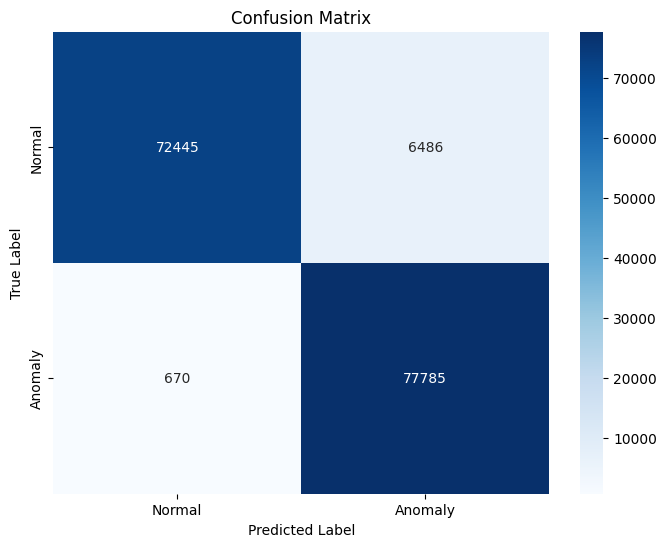


Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.92      0.95     78931
           1       0.92      0.99      0.96     78455

    accuracy                           0.95    157386
   macro avg       0.96      0.95      0.95    157386
weighted avg       0.96      0.95      0.95    157386



In [21]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Make predictions on the test set
y_pred = best_xgb.predict(X_test)

# Generate a confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Anomaly'], yticklabels=['Normal', 'Anomaly'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Print a detailed classification report
print("\nClassification Report:\n", classification_report(y_test, y_pred))


### Precision, Recall, and F1 Curve

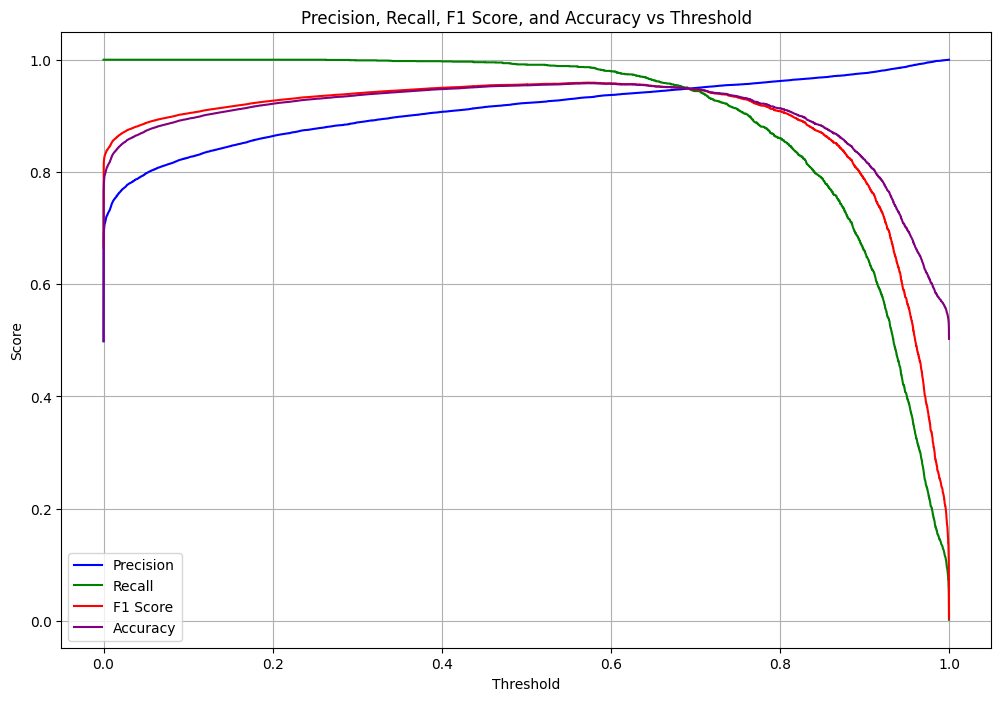

Optimal Threshold (based on F1): 0.5749227
Accuracy at Optimal Threshold: 0.958230083997306


In [22]:
from sklearn.metrics import precision_recall_curve, f1_score, accuracy_score

# Get prediction probabilities for the positive class
y_proba = best_xgb.predict_proba(X_test)[:, 1]

# Calculate precision, recall, and thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)

# Calculate F1 score for each threshold
f1 = 2 * (precision * recall) / (precision + recall)

# Calculate accuracy for each threshold
accuracy = []
for threshold in thresholds:
    y_pred = (y_proba >= threshold).astype(int)
    accuracy.append(accuracy_score(y_test, y_pred))

# Plot Precision, Recall, F1 Score, and Accuracy curves
plt.figure(figsize=(12, 8))
plt.plot(thresholds, precision[:-1], label='Precision', color='blue')
plt.plot(thresholds, recall[:-1], label='Recall', color='green')
plt.plot(thresholds, f1[:-1], label='F1 Score', color='red')
plt.plot(thresholds, accuracy, label='Accuracy', color='purple')
plt.title("Precision, Recall, F1 Score, and Accuracy vs Threshold")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.legend()
plt.grid()
plt.show()

# Print the optimal threshold (based on maximum F1 Score)
optimal_idx = np.argmax(f1)
optimal_threshold = thresholds[optimal_idx]
print("Optimal Threshold (based on F1):", optimal_threshold)

# Print the accuracy at the optimal threshold
optimal_accuracy = accuracy[optimal_idx]
print("Accuracy at Optimal Threshold:", optimal_accuracy)


## Analyzing Feature Importance

<ipython-input-23-a9cfc1024335>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importances, y=features, palette="viridis")


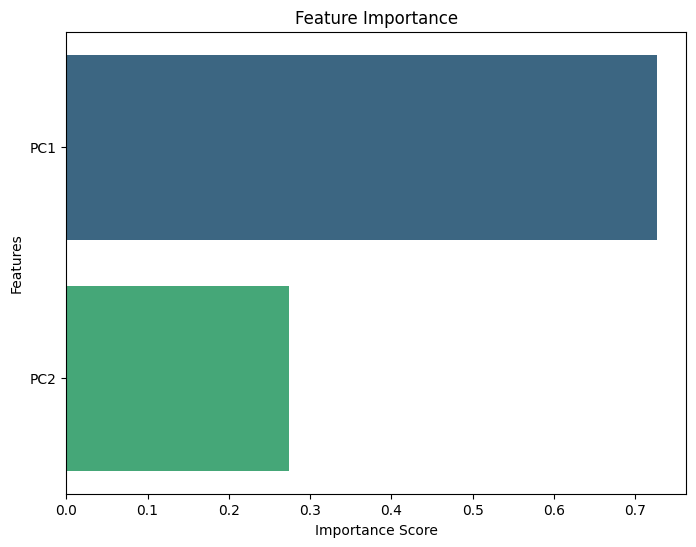

In [23]:
# Feature importance from the XGBoost model
feature_importances = best_xgb.feature_importances_
features = X_train.columns

# Plot feature importance
plt.figure(figsize=(8, 6))
sns.barplot(x=feature_importances, y=features, palette="viridis")
plt.title("Feature Importance")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.show()


### Experimenting with additional features

In [24]:
# Adding GMM cluster probabilities as additional features
gmm_probs = gmm.predict_proba(scaled_data)
for i in range(gmm_probs.shape[1]):
    df[f'Cluster_Prob_{i}'] = gmm_probs[:, i]

# Re-define X to include original features, PCA components, and cluster probabilities
X_new = df[['PC1', 'PC2'] + [f'Cluster_Prob_{i}' for i in range(gmm_probs.shape[1])]]
y_new = df['Anomaly']

# Split into train-test sets again
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(X_new, y_new, test_size=0.3, random_state=42)


### CV for Reliable Metrics

In [25]:
from sklearn.model_selection import cross_val_score

# Perform cross-validation on the best XGBoost model
cv_scores = cross_val_score(best_xgb, X_train, y_train, cv=5, scoring='f1')

# Print average F1 score and standard deviation
print("Cross-Validation F1 Scores:", cv_scores)
print("Mean F1 Score:", np.mean(cv_scores))
print("Standard Deviation:", np.std(cv_scores))


Cross-Validation F1 Scores: [0.95717964 0.9550999  0.9553107  0.95656848 0.9560895 ]
Mean F1 Score: 0.9560496433192138
Standard Deviation: 0.0007740415301431492


### Visualization with ROC-AUC Curve

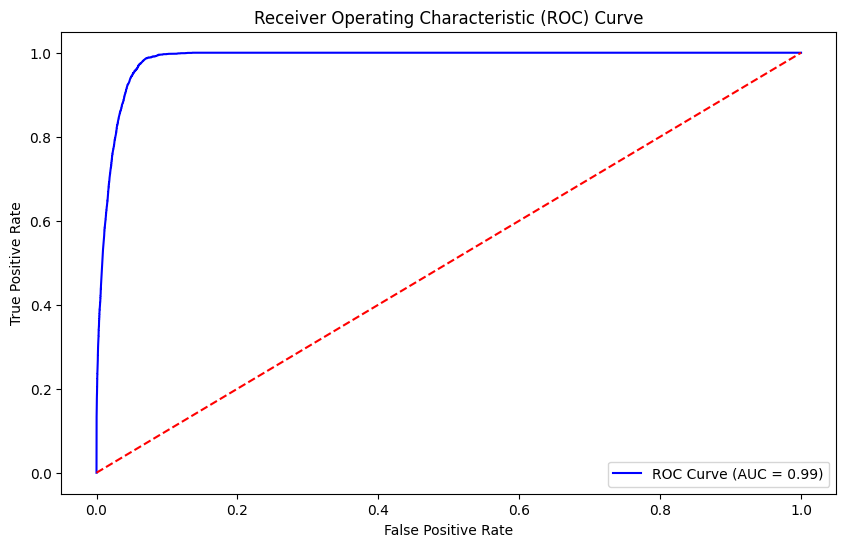

In [26]:
from sklearn.metrics import roc_curve, auc

# Get prediction probabilities for the positive class
y_proba = best_xgb.predict_proba(X_test)[:, 1]

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC-AUC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()


### Hyprparameter Optimization with Randomized Search

In [27]:
from sklearn.model_selection import RandomizedSearchCV

# Define the parameter grid
param_dist = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Perform randomized search
random_search = RandomizedSearchCV(estimator=XGBClassifier(random_state=42),
                                   param_distributions=param_dist,
                                   n_iter=20,
                                   scoring='f1',
                                   cv=3,
                                   random_state=42,
                                   verbose=2)

random_search.fit(X_train, y_train)

# Get the best model and parameters
best_model = random_search.best_estimator_
print("Best Parameters:", random_search.best_params_)


Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=5, n_estimators=100, subsample=0.8; total time=   4.9s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=5, n_estimators=100, subsample=0.8; total time=   2.3s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=5, n_estimators=100, subsample=0.8; total time=   1.6s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=7, n_estimators=200, subsample=0.8; total time=   3.8s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=7, n_estimators=200, subsample=0.8; total time=   6.7s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=7, n_estimators=200, subsample=0.8; total time=   6.7s
[CV] END colsample_bytree=1.0, learning_rate=0.05, max_depth=3, n_estimators=100, subsample=0.8; total time=   1.7s
[CV] END colsample_bytree=1.0, learning_rate=0.05, max_depth=3, n_estimators=100, subsample=0.8; total time=   3.9s
[CV] END colsampl

### Analyze Class Distribution After Prediction

Predicted Class Distribution:
 1    84271
0    73115
Name: count, dtype: int64


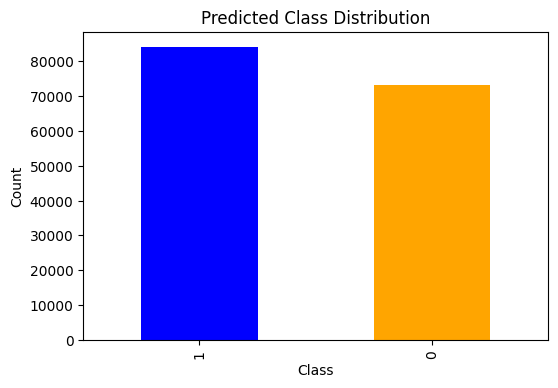

In [28]:
# Predicted class distribution
predicted_class_distribution = pd.Series(best_xgb.predict(X_test)).value_counts()
print("Predicted Class Distribution:\n", predicted_class_distribution)

# Plot predicted class distribution
predicted_class_distribution.plot(kind='bar', color=['blue', 'orange'], figsize=(6, 4))
plt.title("Predicted Class Distribution")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()


### Deploy the model

In [ ]:
from sklearn.pipeline import Pipeline

# Create a complete pipeline
final_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=2)),
    ('classifier', best_xgb)
])

# Fit the pipeline on the entire training dataset
final_pipeline.fit(X_train, y_train)

# Save the final pipeline
with open('drive/MyDrive/Intent-Based Energy Reduction/Models/final_pipeline.pkl', 'wb') as f:
    pickle.dump(final_pipeline, f)
